# FINAL PROJECT SUBMISSION - MODULE 4


* Student name: Maria Antonietta Ricci
* Student pace: Data Science On line - Self-paced 
* Blog post URL: https://datastorytell.wordpress.com/2023/03/29/natural-language-processing-for-information-retrieval-the-basics/

# BUSINESS PROBLEM UNDERSTANDING


This analysis aims to build NLP binary classifier to analyze positive, negative and neutral Twitter sentiment about Apple and Google products.


Stakeholders who could benefit having this information are consumers, the companies themselves (engineers and tech professionals working on the products and the services provided with them), investors and partners as they can be used as insights to improve the customers experience.

### What is Twitter?

Twitter is an online social media and social networking service performed by micro blogging in real time.

### What is Sentiment Analysis?

As per Wipedia definition, sentiment analysis (also known as opinion mining or emotion AI) is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials.


### Models
Chosen models are:

- Gaussian NB.

- Random Forest.

- Support Vector Machine.


### Evaluation
Chosen metrics are:

- Precision.

- Recall.

- F1 score.

- Accuracy score.

- AUC ROC scores.

In [1]:
# Installing needed libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re
import nltk
import itertools
import string

import scipy as sp
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import math
import os

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#  DATA PROCESSING

In [3]:
# Importing and reading dataset
df = pd.read_csv("tweets.csv", encoding = "latin1")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


I proceed exploring the dataset.

In [4]:
# Getting basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.shape

(9093, 3)

### DATASET DESCRIPTION

- It was provided through DataWorld website.

- The dataset chosen for this analysis consists of 9093 entries, spread on 3 columns. Values are tweets expressed positive, negative, or no emotion towards products branded Apple and Google.

- Given the nature of the entries, data type is obj for all three features. In this case, the rating system, even though it is encoded, it is still an obj data.


- It would have been interesting for a more targeted analysis and the identifications of patterns the inclusions of demogrophical data.

- Brief columns description:

    - Column labels are understandable even though not straightforward. Thus, a more clear labeling is needed.
    - Issues like missing values are already identifiable given the summary showed by the info. 

### COLUMNS CHECKING
All columns are kept as needed for the analysis.
Columns labels are changed for clarity purpose.

In [6]:
# Modifying column labels
df.columns = ['tweet_text', 'product_brand', 'sentiment']
df

,tweet_text,product_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


### VALUES CHECKING 

Values have to manipulated in order to make them suitable for analysis.

#### MISSING VALUES

In [7]:
# Checking for missing values
df.isna().sum()

tweet_text          1
product_brand    5802
sentiment           0
dtype: int64

I proceed to check the values.

In [8]:
df["product_brand"].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [9]:
df["sentiment"].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

- In column 1, tweet_text:

    - 1 entry has a missing value. 

    - From the preview it is evident that some rows in this column may not have a sense, as in row 9092, probably for the presence of non ASCII characters. It is necessary to filter those rows.


- In column 2, product_brand:

    - Only a 1/3 of the entries (3291) for products targeted by the Twitter users reviews is present, the remaining 5802 are marked as Nan. The dataset is small and dropping all the entries with no specified product or brand would cut off two third of data,basically nullifying this analytic effort. In this case, remove entries is not an option. I proceed to give a deeper look and I decided to create another category to substitute 'nan' with 'no_product_brand'. 
    - Another issue is posed by the categories,'Other Apple product or service', 'Other Google product of service', which appear to be very wide, unspecified buckets from which could be difficult to draw information.A further investigation led me to state that these buckets contains customers' opinions related to products features like design, accessorizes, services and apps etc. Furthermore I proceed identifying their weight in the dataset. I decide not remove them because they are still reporting sentiment.
     
     
- In column 3, sentiment:
    - the expressions of the rating system used give me my classification terms. For clarity purpose I proceed to clean the terminology used:
    
        - Positive emotion, Positive
        - Negative emotion, Negative
        - No emotion towards product or brand, No emotion
        - I can't tell, No idea
    
     
By data extraction it would be possible to delete rows with ASCII characters and reclassify the rows of tweet_text column from no product to a product, where possible.  

It is clear from this sample that some tweets can be better classified in terms of the product_brand values. 

Before performing a reclassification though, it is necessary to check the related sentiment.
For the purpose of this analysis, I'm interested in those entries marked as Positive or Negative. 
The two categories can be clearly semantically well defineable. 
The other two categories appear to include all the other tweets whose semantic relationships are more complex given the intricacies of human language and thought processising, their extension and infinite possibilities. Context not seen as totally positive or totally negative seems to be marked ar Neutral or Undefined.
This is a brief impression but it is very true that an attempt to reclassify the Neutral entries would be lacking in scientificity as the classification criteria used to assign the customers emotions in primis are not known.
    
   

#### DATA CLEANING

Based on what observed above.

- Deleting NaN from Column1 
- Deleting non ASCII characters
- Deleting HTML tags
- Deleting NaN from Column2 ib No_product_brand
- Modifying Emotions nomenclature in Column3
- Reclassifying values no_product_brand

In [10]:
# Deleting missing values columns for column1
nan_values_tt = df[df['tweet_text'].isna()]
nan_values_tt

,tweet_text,product_brand,sentiment
6,NaN,NaN,No emotion toward brand or product


In [11]:
df['tweet_text'] = df['tweet_text'].str.encode('ascii', 'ignore').str.decode('ascii')

In [12]:
# Modify NaN values in no_product_brand

In [13]:
df[["product_brand"]] = df[["product_brand"]] .fillna('no_product_brand')

In [14]:
df.loc[df['product_brand'] == 'no_product_brand']

,tweet_text,product_brand,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,no_product_brand,No emotion toward brand or product
6,NaN,no_product_brand,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,no_product_brand,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",no_product_brand,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,no_product_brand,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",no_product_brand,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",no_product_brand,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",no_product_brand,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,no_product_brand,No emotion toward brand or product


In [15]:
# Dropping Nan values
df.dropna(inplace = True)
df.head(10)


,tweet_text,product_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,no_product_brand,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [16]:
# Cleaning nomenclature

In [17]:
emo = {"Positive emotion": "positive", "Negative emotion":"negative", "No emotion toward brand or product": "neutral", "I can't tell": "undefined"}
df["sentiment"] = df["sentiment"].map(emo)

In [18]:
# Examining unbranded tweets

In [19]:
df[df["product_brand"] == "no_product_brand"]


,tweet_text,product_brand,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,no_product_brand,neutral
16,Holler Gram for iPad on the iTunes App Store -...,no_product_brand,neutral
32,"Attn: All #SXSW frineds, @mention Register fo...",no_product_brand,neutral
33,Anyone at #sxsw want to sell their old iPad?,no_product_brand,neutral
34,Anyone at #SXSW who bought the new iPad want ...,no_product_brand,neutral
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",no_product_brand,neutral
9089,"Wave, buzz... RT @mention We interrupt your re...",no_product_brand,neutral
9090,"Google's Zeiger, a physician never reported po...",no_product_brand,neutral
9091,Some Verizon iPhone customers complained their...,no_product_brand,neutral


In [20]:
df["sentiment"].value_counts()

neutral      5388
positive     2978
negative      570
undefined     156
Name: sentiment, dtype: int64

In [21]:
data = df.copy()

In [22]:
# Dropping all Neutral and Undefined sentiment related rows 

In [23]:
data = data.loc[(df["sentiment"] != "neutral") & (df["sentiment"] != "undefined")]

In [24]:
# Proceeding with reclassification of No_product_brand

In order to reclassify the tweets we start with the basic nomenclature used for classification in column product_brand: Apple, iPhone, iPad, iPad or iPhone App, Other Apple product and service; Google, Android, Android App, Other Google product and service.
I proceed to find all the possible combinations.

In [25]:
data["product_brand"].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'no_product_brand', 'Other Apple product or service'], dtype=object)

In [26]:
item1 = ["Apple", "iPhone", "iPad", "Google", "Android"]
item2 = ["App"]
res2 = [[i] for i in item1]
res12 = [[i, j] for i in item1
              for j in item2]
print(res2, res12)

[['Apple'], ['iPhone'], ['iPad'], ['Google'], ['Android']] [['Apple', 'App'], ['iPhone', 'App'], ['iPad', 'App'], ['Google', 'App'], ['Android', 'App']]


In [27]:
keys = ["Apple", "iPhone", "iPad", "Google", "Android", "App", "Apple App", "iPhone App", "iPad App", "Google App", "Android App"]

In [28]:
# Reclassifying no product_brand

In [29]:
data["product_brand"][df['product_brand'] == "no_product_brand"]= data.tweet_text.str.findall('({0})'.format('|'.join(keys)), flags=re.IGNORECASE)

In [30]:
data = data.explode("product_brand")

In [31]:
data1 = data.dropna()

I establish some basic classes given the terms found in them:

- same index apple + app > apple

- same index google + app > google

- same index iphone + app > phone or ipad app

- same index ipad + app > iphone or ipad app

- same index android + app > android app

- same index apple + iphone > iphone

- same index apple + ipad > ipad

- same index google + android > android 

Since it is a very small subset I go throught it manually in order to ensure the correct classification. There may be other combinations.

In [32]:
data1[data1.index.duplicated(keep=False)]

,tweet_text,product_brand,sentiment
46,Hand-Held Hobo: Drafthouse launches Hobo With ...,iPhone,positive
46,Hand-Held Hobo: Drafthouse launches Hobo With ...,app,positive
68,Boooo! RT @mention Flipboard is developing an ...,iPhone,negative
68,Boooo! RT @mention Flipboard is developing an ...,Android,negative
112,Spark for #android is up for a #teamandroid aw...,android,positive
112,Spark for #android is up for a #teamandroid aw...,android,positive
131,Does your #SmallBiz need reviews to play on Go...,Google,positive
131,Does your #SmallBiz need reviews to play on Go...,App,positive
337,First day at sxsw. Fun final presentation on ...,Google,positive
337,First day at sxsw. Fun final presentation on ...,Google,positive


In [33]:
data1.loc[1092,"product_brand"]="iphone"
data1.loc[(8250,112), "product_brand"]="android"
data1.loc[(4206,3792,3269,2566), "product_brand"]="android app"
data1.loc[(7343,6845,4230,2428,2059,440), "product_brand"]="apple"
data1.loc[(7983,7223,4990,4919,2512,2022,1954,1803,1533,1286,962,68,6772, 7561, 2258, 2202, 1366, 619,1862,5613, 5791, 6606, 8196, 8811),"product_brand"]="undefined"
data1.loc[(7701,7562,7285,6942,6632,5976,5930,5851, 5089, 4958, 4336, 3521,1365,1063,585,337,131, 4364),"product_brand"]="google"
data1.loc[(9043,9011,8482,8379,8058,7695,7308, 6802, 6738, 6674, 6436, 6349, 6343, 6327, 6236, 6078, 4220, 3984, 3861, 3055, 6287, 3780, 3537,3425, 3353, 1962, 1903, 1740,1370, 1369,1284, 666, 662, 611, 598, 500, 46, 4212),"product_brand"]="ipad or iphone app"
data1.loc[(9052,8245,8002,7990,7804,7412,7260,7117,6661,6309,6256,6180,6069,3179,5586, 5569, 5568, 5554, 5412, 5401,5240, 5015, 4831, 4674,4536, 4303, 4074, 3829, 3710, 3698, 3020, 2983, 2596, 2493, 2468, 1273, 867, 682, 639, 417),"product_brand"]= "ipad"

In [34]:
# Dropping duplicates
data2 = data1.drop_duplicates()
data2.shape


(3533, 3)

In [35]:
# Dropping undefined
undefined = data2[(data2['product_brand'] =="undefined")].index
data2.drop(undefined, inplace=True)


In [36]:
# Lowercase to unsure uniformity and sum up

In [37]:
data2['product_brand']=data2['product_brand'].str.lower()

In [38]:
data2['product_brand'].value_counts()

ipad                               1012
apple                               671
google                              522
ipad or iphone app                  497
iphone                              321
other google product or service     283
android                              86
android app                          83
other apple product or service       34
Name: product_brand, dtype: int64

#### TEXT PREPROCESSING

In [39]:
# Clean punctuation 

In [40]:
def clean_punc(doc):
    for x in doc:
        new_doc = "".join([w for w in doc if w not in string.punctuation])
    return new_doc

In [41]:
data2['tweet_text']= data2['tweet_text'].map(lambda x: clean_punc(x))

In [42]:
# Remove HTML characters and tags

In [43]:
from bs4 import BeautifulSoup
# Function to remove tags
def remove_tags(html):
    # parse html content
    soup = BeautifulSoup(html, "lxml")
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)
# Print the extracted data

In [44]:
data2['tweet_text']= data2['tweet_text'].map(lambda x: remove_tags(x))

In [45]:
# Tokenize words

In [46]:
 from nltk.tokenize import word_tokenize

In [47]:
data2['word_token']= data2['tweet_text'].map(lambda x: word_tokenize(x.lower()))

In [48]:
data2.reset_index()


,index,tweet_text,product_brand,sentiment,word_token
0,0,wesley83 I have a 3G iPhone After 3 hrs tweeti...,iphone,negative,"[wesley83, i, have, a, 3g, iphone, after, 3, h..."
1,1,jessedee Know about fludapp Awesome iPadiPhon...,ipad or iphone app,positive,"[jessedee, know, about, fludapp, awesome, ipad..."
2,2,swonderlin Can not wait for iPad 2 also They s...,ipad,positive,"[swonderlin, can, not, wait, for, ipad, 2, als..."
3,3,sxsw I hope this years festival isnt as crashy...,ipad or iphone app,negative,"[sxsw, i, hope, this, years, festival, isnt, a..."
4,4,sxtxstate great stuff on Fri SXSW Marissa Maye...,google,positive,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."
...,...,...,...,...,...
3504,9077,mention your PR guy just convinced me to switc...,iphone,positive,"[mention, your, pr, guy, just, convinced, me, ..."
3505,9079,quotpapyrussort of like the ipadquot nice Lol...,ipad,positive,"[quotpapyrussort, of, like, the, ipadquot, nic..."
3506,9080,Diller says Google TV quotmight be run over by...,other google product or service,negative,"[diller, says, google, tv, quotmight, be, run,..."
3507,9085,Ive always used Camera for my iPhone bc it has...,ipad or iphone app,positive,"[ive, always, used, camera, for, my, iphone, b..."


In [49]:
data2['word_token'].to_list()

[['wesley83',
  'i',
  'have',
  'a',
  '3g',
  'iphone',
  'after',
  '3',
  'hrs',
  'tweeting',
  'at',
  'riseaustin',
  'it',
  'was',
  'dead',
  'i',
  'need',
  'to',
  'upgrade',
  'plugin',
  'stations',
  'at',
  'sxsw'],
 ['jessedee',
  'know',
  'about',
  'fludapp',
  'awesome',
  'ipadiphone',
  'app',
  'that',
  'youll',
  'likely',
  'appreciate',
  'for',
  'its',
  'design',
  'also',
  'theyre',
  'giving',
  'free',
  'ts',
  'at',
  'sxsw'],
 ['swonderlin',
  'can',
  'not',
  'wait',
  'for',
  'ipad',
  '2',
  'also',
  'they',
  'should',
  'sale',
  'them',
  'down',
  'at',
  'sxsw'],
 ['sxsw',
  'i',
  'hope',
  'this',
  'years',
  'festival',
  'isnt',
  'as',
  'crashy',
  'as',
  'this',
  'years',
  'iphone',
  'app',
  'sxsw'],
 ['sxtxstate',
  'great',
  'stuff',
  'on',
  'fri',
  'sxsw',
  'marissa',
  'mayer',
  'google',
  'tim',
  'oreilly',
  'tech',
  'booksconferences',
  'amp',
  'matt',
  'mullenweg',
  'wordpress'],
 ['sxsw',
  'is',
  'ju

In [50]:
# Cleaning stopwords

In [51]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [52]:
data2['word_token'] = data2['word_token'].apply(lambda x: [item for item in x if item not in stop])
data2

,tweet_text,product_brand,sentiment,word_token
0,wesley83 I have a 3G iPhone After 3 hrs tweeti...,iphone,negative,"[wesley83, 3g, iphone, 3, hrs, tweeting, risea..."
1,jessedee Know about fludapp Awesome iPadiPhon...,ipad or iphone app,positive,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,swonderlin Can not wait for iPad 2 also They s...,ipad,positive,"[swonderlin, wait, ipad, 2, also, sale, sxsw]"
3,sxsw I hope this years festival isnt as crashy...,ipad or iphone app,negative,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,sxtxstate great stuff on Fri SXSW Marissa Maye...,google,positive,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...
9077,mention your PR guy just convinced me to switc...,iphone,positive,"[mention, pr, guy, convinced, switch, back, ip..."
9079,quotpapyrussort of like the ipadquot nice Lol...,ipad,positive,"[quotpapyrussort, like, ipadquot, nice, lol, s..."
9080,Diller says Google TV quotmight be run over by...,other google product or service,negative,"[diller, says, google, tv, quotmight, run, pla..."
9085,Ive always used Camera for my iPhone bc it has...,ipad or iphone app,positive,"[ive, always, used, camera, iphone, bc, image,..."


In [53]:
data2.reset_index(inplace = True)
data2

,index,tweet_text,product_brand,sentiment,word_token
0,0,wesley83 I have a 3G iPhone After 3 hrs tweeti...,iphone,negative,"[wesley83, 3g, iphone, 3, hrs, tweeting, risea..."
1,1,jessedee Know about fludapp Awesome iPadiPhon...,ipad or iphone app,positive,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,2,swonderlin Can not wait for iPad 2 also They s...,ipad,positive,"[swonderlin, wait, ipad, 2, also, sale, sxsw]"
3,3,sxsw I hope this years festival isnt as crashy...,ipad or iphone app,negative,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,4,sxtxstate great stuff on Fri SXSW Marissa Maye...,google,positive,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...,...
3504,9077,mention your PR guy just convinced me to switc...,iphone,positive,"[mention, pr, guy, convinced, switch, back, ip..."
3505,9079,quotpapyrussort of like the ipadquot nice Lol...,ipad,positive,"[quotpapyrussort, like, ipadquot, nice, lol, s..."
3506,9080,Diller says Google TV quotmight be run over by...,other google product or service,negative,"[diller, says, google, tv, quotmight, run, pla..."
3507,9085,Ive always used Camera for my iPhone bc it has...,ipad or iphone app,positive,"[ive, always, used, camera, iphone, bc, image,..."


# EXPLORATIVE DATA ANALYSIS

I start the EDA with some basic views of the numbers related to the products and the reactions.

In [54]:
data2['sentiment'].value_counts()


positive    2943
negative     566
Name: sentiment, dtype: int64

In [55]:
data2.sentiment.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

positive    83.9%
negative    16.1%
Name: sentiment, dtype: object

In [56]:
data2['product_brand'].value_counts()

ipad                               1012
apple                               671
google                              522
ipad or iphone app                  497
iphone                              321
other google product or service     283
android                              86
android app                          83
other apple product or service       34
Name: product_brand, dtype: int64

In [58]:
data2.product_brand.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

ipad                               28.8%
apple                              19.1%
google                             14.9%
ipad or iphone app                 14.2%
iphone                              9.1%
other google product or service     8.1%
android                             2.5%
android app                         2.4%
other apple product or service      1.0%
Name: product_brand, dtype: object

In [60]:
sent_prod = data2.groupby(['product_brand',"sentiment"]).count()
sent_prod

index  tweet_text  word_token
product_brand                   sentiment                               
android                         negative       9           9           9
                                positive      77          77          77
android app                     negative       9           9           9
                                positive      74          74          74
apple                           negative     100         100         100
                                positive     571         571         571
google                          negative      86          86          86
                                positive     436         436         436
ipad                            negative     136         136         136
                                positive     876         876         876
ipad or iphone app              negative      68          68          68
                                positive     429         429         429
iphone                          negative     109         109         109
                                positive     212         212         212
other apple product or service  negative       2           2           2
                                positive      32          32          32
other google product or service negative      47          47          47
                                positive     236         236         236

## SENTIMENT ANALYSIS 

I proceed to create another column in order to better slice the dataset between the two companies and leaving room for further potential analysis.

### APPLE

In [61]:
data2['company'] = data2.loc[:, 'product_brand']
data2['company'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service',
       'other apple product or service'], dtype=object)

In [62]:
# Replacing values for Apple

In [63]:
data2.loc[data2["company"] == "iphone", "company"] = "apple"
data2.loc[data2["company"] == "ipad or iphone app", "company"] = "apple"
data2.loc[data2["company"] == "ipad", "company"] = "apple"
data2.loc[data2["company"] == "other apple product or service", "company"] = "apple"

In [64]:
# Replacing values for Google 

In [65]:
data2.loc[data2["company"] == "android", "company"] = "google"
data2.loc[data2["company"] == "android app", "company"] = "google"
data2.loc[data2["company"] == "other google product or service", "company"] = "google"

Text(0.5, 1.0, 'Apple Other Services Sentiment Count')

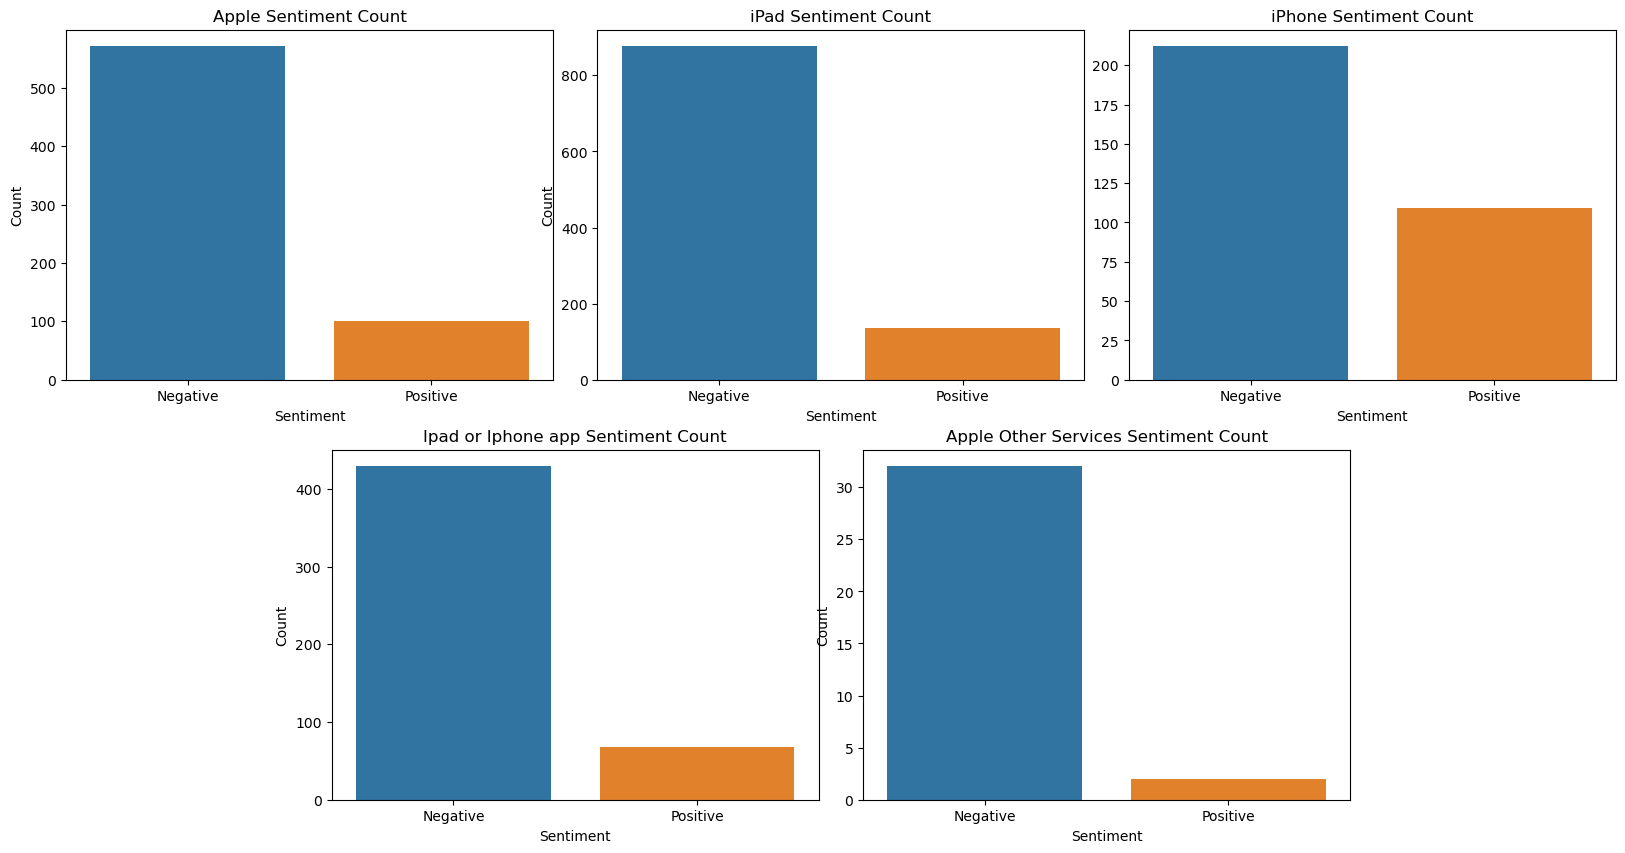

In [67]:
# Exploring through plot sentiments towards Apple and its products

plt.figure(figsize=(20,10))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
# Apple
sns.barplot(x=data2.loc[data2.product_brand == 'apple']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'apple']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'apple'], 
            ax=ax1)
ax1.set_xticklabels(['Negative', 'Positive'])
ax1.set_xlabel('Sentiment', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Apple Sentiment Count',fontsize=12)

#Ipad

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
sns.barplot(x=data2.loc[data2.product_brand == 'ipad']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'ipad']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'ipad'], 
            ax=ax2)
ax2.set_xticklabels(['Negative', 'Positive'])
ax2.set_xlabel('Sentiment', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('iPad Sentiment Count',fontsize=12)


# Iphone
sns.barplot(x=data2.loc[data2.product_brand == 'iphone']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'iphone']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'iphone'], 
            ax=ax3)
ax3.set_xticklabels(['Negative', 'Positive'])
ax3.set_xlabel('Sentiment', fontsize=10)
ax3.set_ylabel('Count', fontsize=10)
ax3.set_title('iPhone Sentiment Count',fontsize=12)


# Ipad, Iphone App
sns.barplot(x=data2.loc[data2.product_brand == 'ipad or iphone app']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'ipad or iphone app']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'ipad or iphone app'], 
            ax=ax4)
ax4.set_xticklabels(['Negative', 'Positive'])
ax4.set_xlabel('Sentiment', fontsize=10)
ax4.set_ylabel('Count', fontsize=10)
ax4.set_title('Ipad or Iphone app Sentiment Count',fontsize=12)


# Other services
sns.barplot(x=data2.loc[data2.product_brand == 'other apple product or service']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'other apple product or service']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'other apple product or service'], 
            ax=ax5)
ax5.set_xticklabels(['Negative', 'Positive'])
ax5.set_xlabel('Sentiment', fontsize=10)
ax5.set_ylabel('Count', fontsize=10)
ax5.set_title('Apple Other Services Sentiment Count',fontsize=12)

#### POSITIVE TWEETS for APPLE

I proceed to look into the positive tweets numbers for Apple.


In [70]:
# Selecting a subset accordingly
pos_apple =  data2.loc[(data2["company"] == 'apple') & (data2["sentiment"] == 'positive')]

In [71]:
# Creating the BoW
from collections import Counter

In [72]:
# Preparing the data for the vectorization

In [73]:
ap_pos_tw = pos_apple["word_token"].to_dict()

In [74]:
appl_pw = []
for key, value in (
        itertools.chain.from_iterable(
            [itertools.product((k, ), v) for k, v in ap_pos_tw.items()])):
                appl_pw.append(value)

In [75]:
# Proceeding with the vectorization
def count_vectorize(list_w):
    counts = Counter(list_w)
    return dict(counts)
apple_pos_vect_words = count_vectorize(appl_pw)

In [76]:
from nltk import FreqDist
apple_pos_freq = FreqDist(apple_pos_vect_words)
apple_pos_20 = apple_pos_freq.most_common(50)

In [77]:
# Conversion for easier plotting
apple_pos_dist = pd.Series(dict(apple_pos_20))

Text(0.5, 1.0, 'Most frequent words for Apple positive tweets')

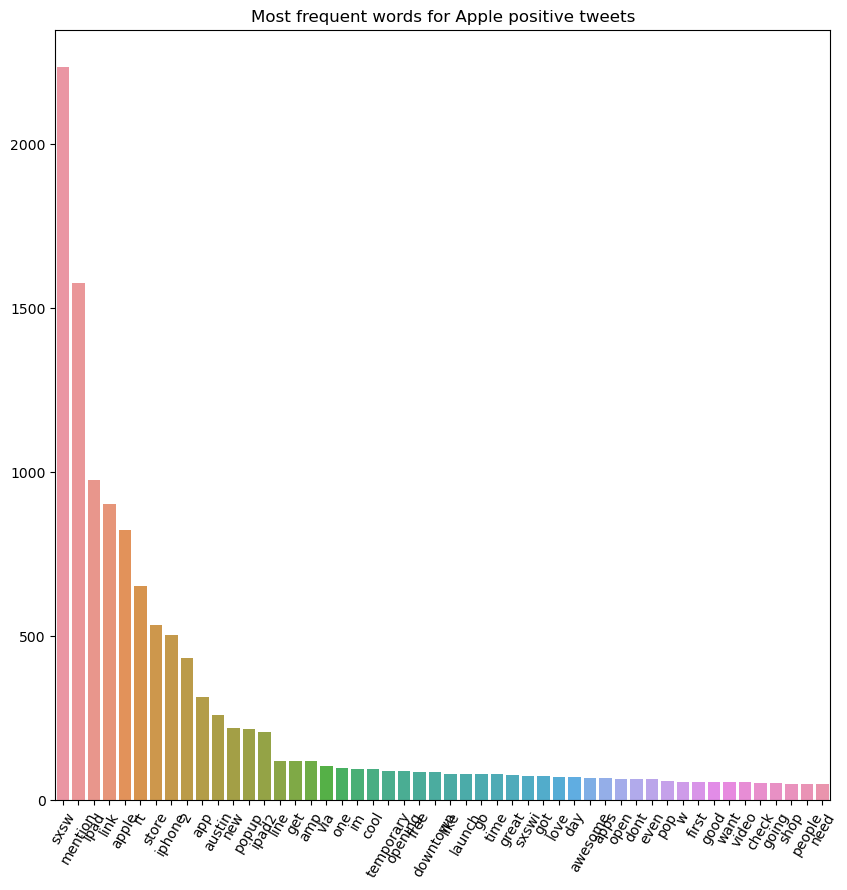

In [81]:
# Seaborn plotting 
fig, ax = plt.subplots(figsize=(10,10))
all_plot = sns.barplot(x=apple_pos_dist.index, y=apple_pos_dist.values, ax=ax)
plt.xticks(rotation=60);
plt.title('Most frequent words for Apple positive tweets',fontsize=12)

In [82]:
# Calculating bigrams
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [83]:
#initializing finder
finder_apple_pos = BigramCollocationFinder.from_words(appl_pw)
#getting frequency information from finder
bigrams_apple_pos = finder_apple_pos.score_ngrams(bigram_measures.raw_freq)
#displaying top 50 bigrams
bigrams_apple_pos[:10]

[(('rt', 'mention'), 0.02402080783353733),
 (('ipad', '2'), 0.014764381884944921),
 (('sxsw', 'link'), 0.009103427172582619),
 (('apple', 'store'), 0.008032435740514076),
 (('mention', 'sxsw'), 0.006234700122399021),
 (('iphone', 'app'), 0.004895960832313341),
 (('sxsw', 'apple'), 0.0047812117503059975),
 (('popup', 'store'), 0.004666462668298654),
 (('link', 'rt'), 0.004628212974296206),
 (('store', 'sxsw'), 0.00436046511627907)]

In [84]:
# Calculating pmi scores
apple_pos_pmi_finder = BigramCollocationFinder.from_words(appl_pw)
apple_pos_pmi_scored =apple_pos_pmi_finder.score_ngrams(bigram_measures.pmi)
apple_pos_pmi_scored

[(('02', 'symbian'), 14.674192268145683),
 (('100s', 'emails'), 14.674192268145683),
 (('11', 'accommodate'), 14.674192268145683),
 (('12th', 'zaarlyiscoming'), 14.674192268145683),
 (('14', 'million'), 14.674192268145683),
 (('15slides', 'gruber'), 14.674192268145683),
 (('16mins', 'quotthat'), 14.674192268145683),
 (('1991', '169'), 14.674192268145683),
 (('2012345', 'ijustshatmyfanboyknickers'), 14.674192268145683),
 (('2day', '4android'), 14.674192268145683),
 (('2honor', 'suffered'), 14.674192268145683),
 (('320', 'scoremore'), 14.674192268145683),
 (('330', 'sheraton'), 14.674192268145683),
 (('36', 'degrees'), 14.674192268145683),
 (('4chan', 'internets'), 14.674192268145683),
 (('4g', 'connectivity'), 14.674192268145683),
 (('5000', 'sq'), 14.674192268145683),
 (('58967', 'visits'), 14.674192268145683),
 (('630am', '36'), 14.674192268145683),
 (('985', 'iphones'), 14.674192268145683),
 (('aber', 'leider'), 14.674192268145683),
 (('actors', 'diet'), 14.674192268145683),
 (('adap

In [85]:
#defining a function for wordcloud generation positive
def generate_wordcloud(tokens, collocations=False, background_color='black', 
                       colormap='Greens', display=True):

# Initalize a WordCloud
    wordcloud = WordCloud(collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap, 
                          width=500, height=300)
# Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

# Plot 
    if display:
        plt.figure(figsize = (12, 15), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
    return wordcloud

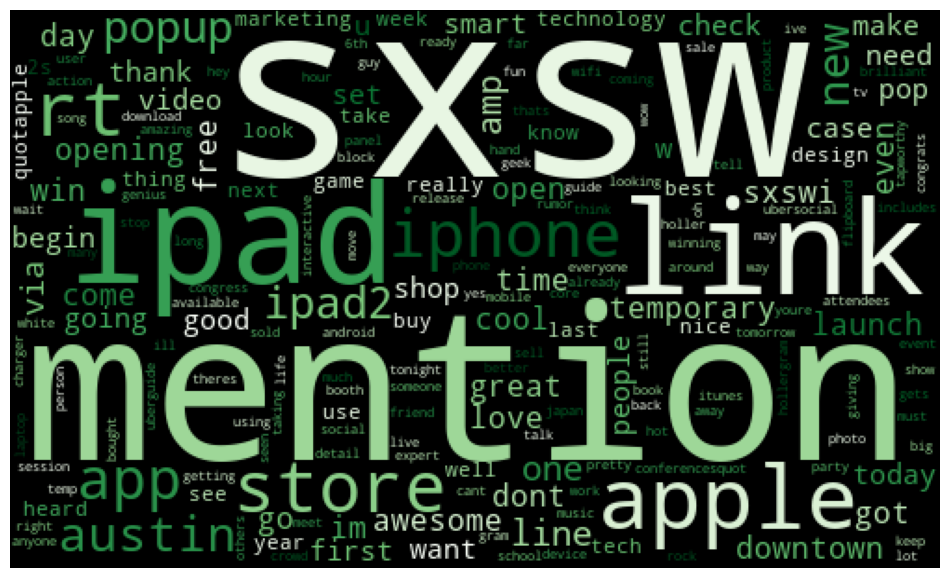

In [86]:
#generating word cloud plot
wd_cloud_apple_pos = generate_wordcloud(appl_pw, collocations=False)

#### NEGATIVE TWEETS for APPLE

In [172]:
# Selecting a subset accordingly

In [173]:
neg_apple =  data2.loc[(data2["company"] == 'apple') & (data2["sentiment"] == 'negative')]

In [174]:
# Preparing the data for the vectorization

In [175]:
ap_neg_tw = neg_apple["word_token"].to_dict()

In [176]:
appl_nw = []
for key, value in (
        itertools.chain.from_iterable(
            [itertools.product((k, ), v) for k, v in ap_neg_tw.items()])):
                appl_nw.append(value)

In [177]:
apple_neg_vect_words = count_vectorize(appl_nw)

In [178]:
# Calculating most frequent words

In [179]:
apple_neg_freq = FreqDist(apple_neg_vect_words)
apple_neg_20 = apple_neg_freq.most_common(20)

In [180]:
## Conversion for easier plotting
apple_neg_dist = pd.Series(dict(apple_neg_20))

Text(0.5, 1.0, 'Most frequent words for Apple negative tweets')

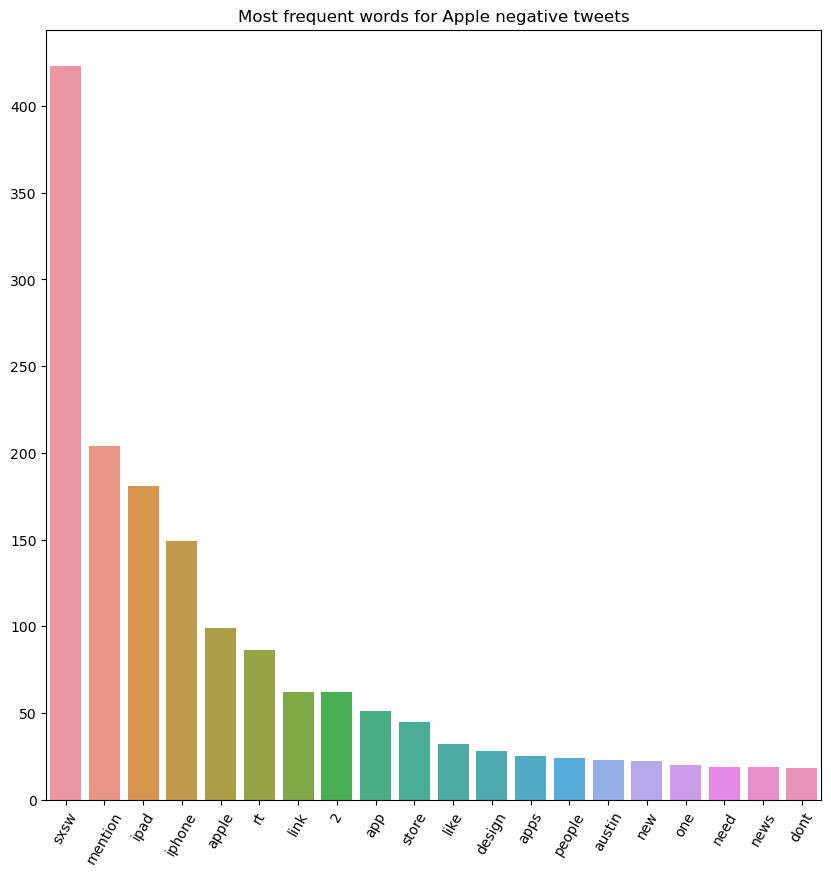

In [181]:
# Seaborn plots
fig, ax = plt.subplots(figsize=(10,10))
all_plot = sns.barplot(x=apple_neg_dist.index, y=apple_neg_dist.values, ax=ax)
plt.xticks(rotation=60);
plt.title('Most frequent words for Apple negative tweets',fontsize=12)

In [182]:
#initializing finder
finder_apple_neg = BigramCollocationFinder.from_words(appl_nw)
#getting frequency information from finder
bigrams_apple_neg = finder_apple_neg.score_ngrams(bigram_measures.raw_freq)
#displaying top 50 bigrams
bigrams_apple_neg[:10]

[(('rt', 'mention'), 0.01708382995629718),
 (('ipad', '2'), 0.009733810091378626),
 (('sxsw', 'rt'), 0.006952721493841876),
 (('mention', 'sxsw'), 0.004966229638458482),
 (('apple', 'store'), 0.004370282081843465),
 (('sxsw', 'iphone'), 0.004370282081843465),
 (('iphone', 'app'), 0.004171632896305125),
 (('sxsw', 'link'), 0.003575685339690107),
 (('ipad', 'design'), 0.0031783869686134287),
 (('sxsw', 'mention'), 0.0031783869686134287)]

In [183]:
#Calculating pmi score
apple_neg_pmi_finder = BigramCollocationFinder.from_words(appl_nw)
apple_neg_pmi_scored =apple_neg_pmi_finder.score_ngrams(bigram_measures.pmi)

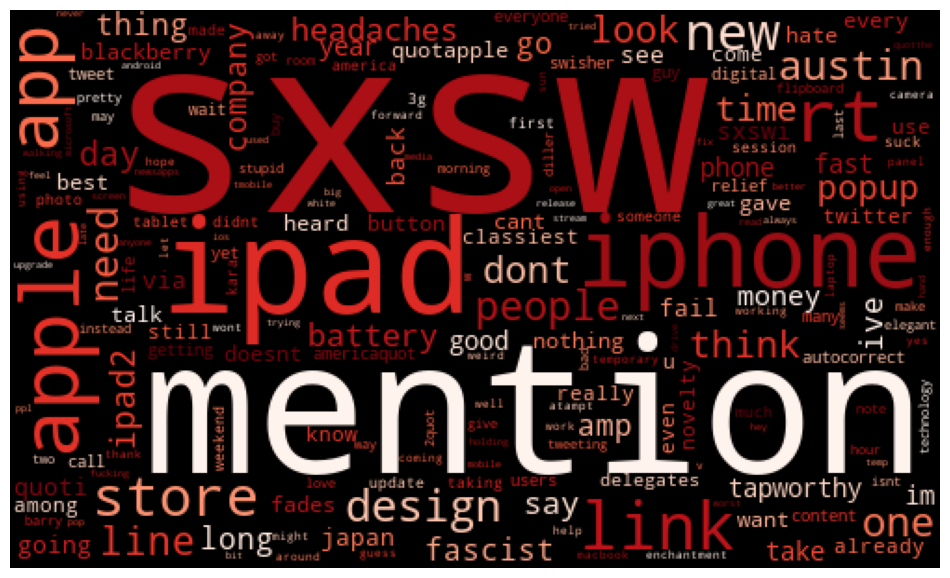

In [184]:
# Generating wordcloud plot

wd_cloud_apple_neg = generate_wordcloud(appl_nw, collocations=False, background_color='black', 
                       colormap='Reds', display=True)

### GOOGLE

I proceed to look into the positive tweets numbers for Google.

Text(0.5, 1.0, 'Google Other Services Sentiment Count')

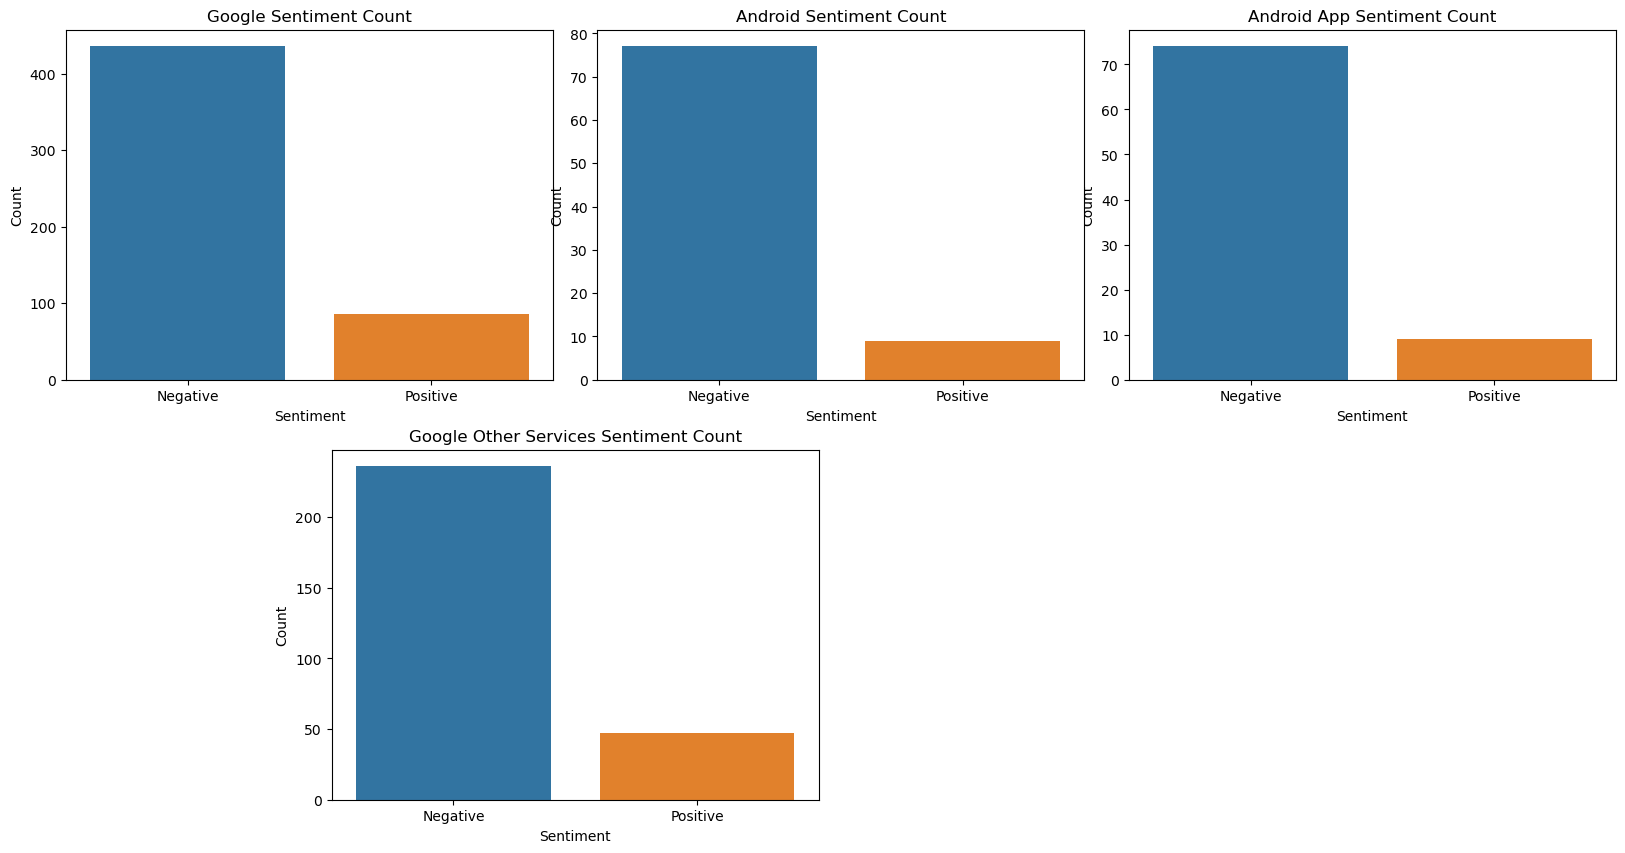

In [105]:
# Exploring through plot sentiments towards Google and its products
plt.figure(figsize=(20,10))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)

# Google
sns.barplot(x=data2.loc[data2.product_brand == 'google']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'google']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'google'], 
            ax=ax1)
ax1.set_xticklabels(['Negative', 'Positive'])
ax1.set_xlabel('Sentiment', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Google Sentiment Count',fontsize=12)

#Android

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
sns.barplot(x=data2.loc[data2.product_brand == 'android']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'android']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'android'], 
            ax=ax2)
ax2.set_xticklabels(['Negative', 'Positive'])
ax2.set_xlabel('Sentiment', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('Android Sentiment Count',fontsize=12)


# Android App
sns.barplot(x=data2.loc[data2.product_brand == 'android app']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'android app']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'android app'], 
            ax=ax3)
ax3.set_xticklabels(['Negative', 'Positive'])
ax3.set_xlabel('Sentiment', fontsize=10)
ax3.set_ylabel('Count', fontsize=10)
ax3.set_title('Android App Sentiment Count',fontsize=12)



# Other services
sns.barplot(x=data2.loc[data2.product_brand == 'other google product or service']['sentiment'].value_counts().index,
            y=data2.loc[data2.product_brand == 'other google product or service']['sentiment'].value_counts().values, 
            data=data2.loc[data2.product_brand == 'other google product or service'], 
            ax=ax4)
ax4.set_xticklabels(['Negative', 'Positive'])
ax4.set_xlabel('Sentiment', fontsize=10)
ax4.set_ylabel('Count', fontsize=10)
ax4.set_title('Google Other Services Sentiment Count',fontsize=12)

#### POSITIVE TWEETS for GOOGLE

In [107]:
# Selecting the subset accordingly

In [114]:
pos_google =  data2.loc[(data2["company"] == 'google') & (data2["sentiment"] == 'positive')]

In [115]:
# Preparing for the tokenization

In [116]:
ggl_pos_tw = pos_google["word_token"].to_dict()

In [117]:
ggl_pw = []
for key, value in (
        itertools.chain.from_iterable(
            [itertools.product((k, ), v) for k, v in ggl_pos_tw.items()])):
                ggl_pw.append(value)

In [118]:
google_pos_vect_words = count_vectorize(ggl_pw)

In [121]:
google_pos_freq = FreqDist(google_pos_vect_words)
google_pos_20 = google_pos_freq.most_common(20)

In [122]:
# Conversion easier plotting
google_pos_dist = pd.Series(dict(google_pos_20))

Text(0.5, 1.0, 'Most frequent words for Google positive tweets')

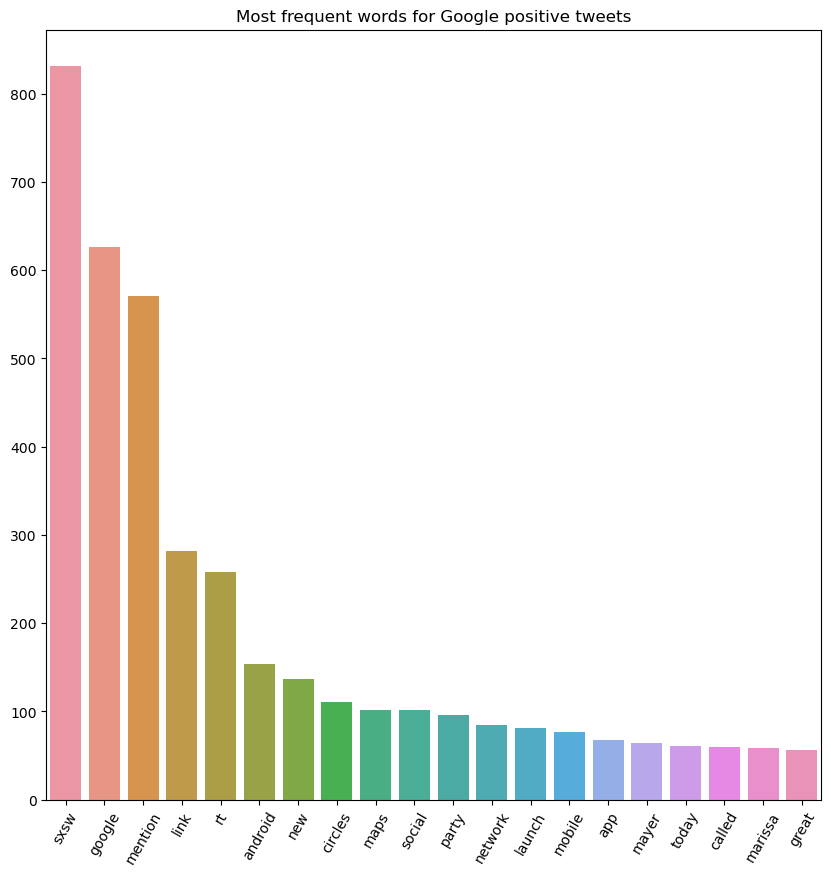

In [123]:
# Seaborn plots
fig, ax = plt.subplots(figsize=(10,10))
all_plot = sns.barplot(x=google_pos_dist.index, y=google_pos_dist.values, ax=ax)
plt.xticks(rotation=60);
plt.title('Most frequent words for Google positive tweets',fontsize=12)

In [125]:
#Calculate bigrams
#initializing finder
finder_google_pos = BigramCollocationFinder.from_words(ggl_pw)
#getting frequency information from finder
bigrams_google_pos = finder_google_pos.score_ngrams(bigram_measures.raw_freq)
#displaying top 50 bigrams
bigrams_google_pos[:10]

[(('rt', 'mention'), 0.024436807941962582),
 (('mention', 'google'), 0.008781977854142803),
 (('link', 'sxsw'), 0.008018327605956471),
 (('social', 'network'), 0.007731958762886598),
 (('sxsw', 'rt'), 0.0074455899198167235),
 (('new', 'social'), 0.007350133638793432),
 (('google', 'maps'), 0.00715922107674685),
 (('sxsw', 'google'), 0.006491027109583811),
 (('sxsw', 'link'), 0.006013745704467354),
 (('google', 'launch'), 0.005918289423444063)]

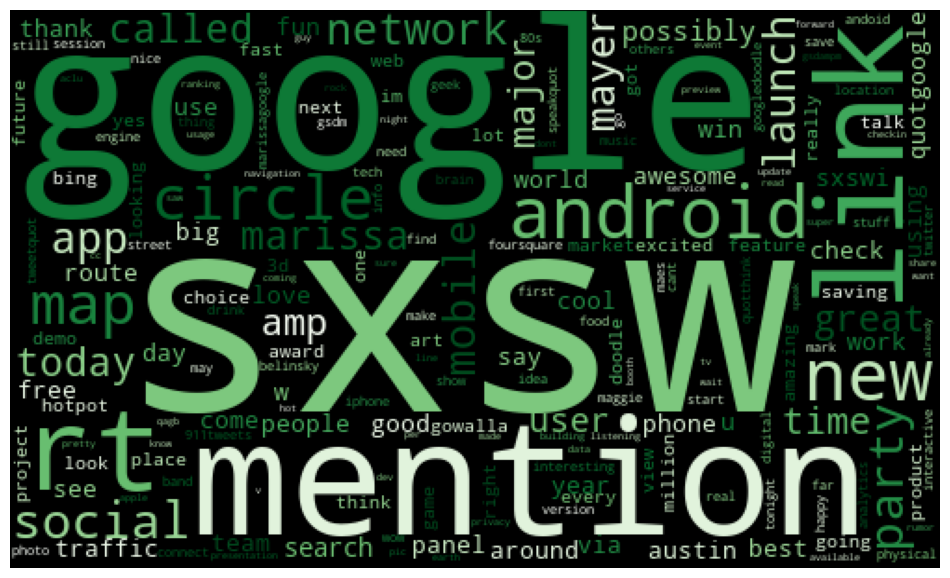

In [126]:
# Generate wordcloud plot
wd_cloud_apple_pos = generate_wordcloud(ggl_pw, collocations=False)

#### NEGATIVE TWEETS for GOOGLE

In [127]:
# Selecting the subset accordingly

In [129]:
neg_google =  data2.loc[(data2["company"] == 'google') & (data2["sentiment"] == 'negative')]

In [130]:
#preparing for the tokenization

In [131]:
ggl_neg_tw = neg_google["word_token"].to_dict()

In [132]:
ggl_nw = []
for key, value in (
        itertools.chain.from_iterable(
            [itertools.product((k, ), v) for k, v in ggl_neg_tw.items()])):
                ggl_nw.append(value)

In [133]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens

In [134]:
google_neg_vect_words = count_vectorize(ggl_nw)

In [135]:
google_neg_freq = FreqDist(google_neg_vect_words)
google_neg_20 = google_neg_freq.most_common(20)

Text(0.5, 1.0, 'Most frequent words for Google negative tweets')

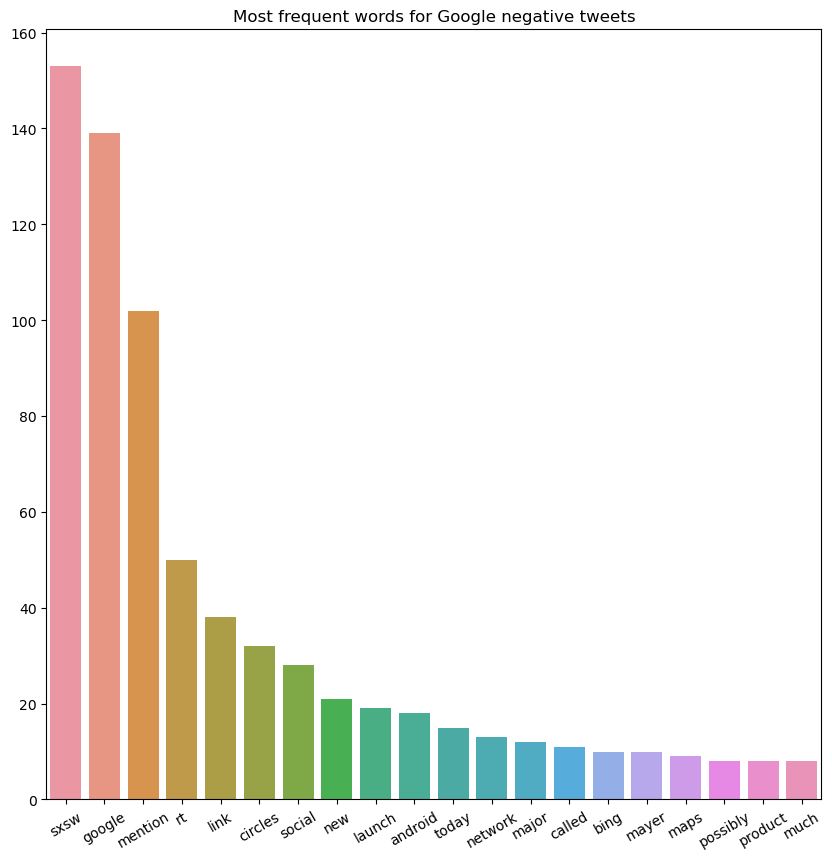

In [136]:
# Seaborn plots
google_neg_dist = pd.Series(dict(google_neg_20))
fig, ax = plt.subplots(figsize=(10,10))
all_plot = sns.barplot(x=google_neg_dist.index, y=google_neg_dist.values, ax=ax)
plt.xticks(rotation=30);
plt.title('Most frequent words for Google negative tweets',fontsize=12)

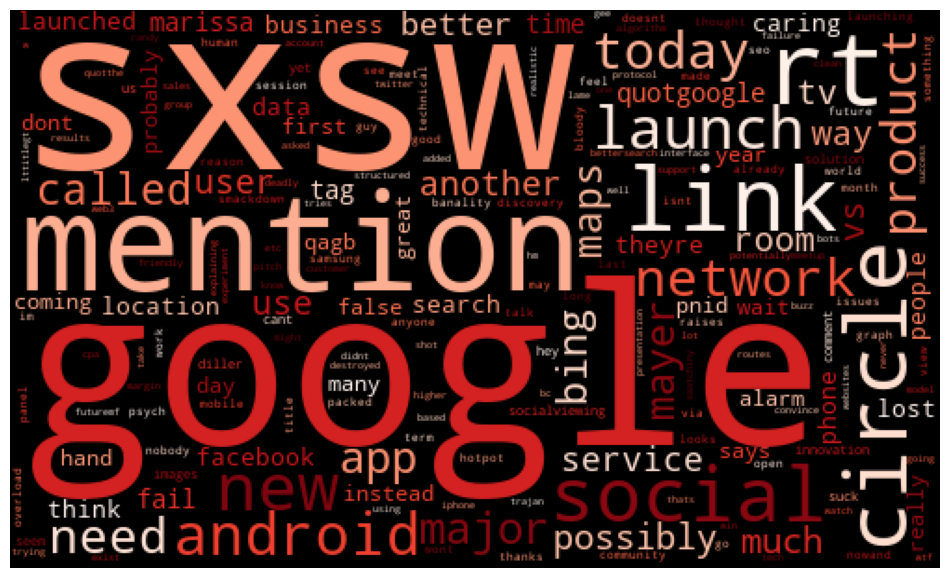

In [137]:
#Generate wordcloud plot
wd_cloud_google_neg = generate_wordcloud(ggl_nw, collocations=False, background_color='black', 
                       colormap='Reds', display=True)

In [138]:
# Calculating the bigrams
#initializing finder
finder_google_neg = BigramCollocationFinder.from_words(ggl_nw)
#getting frequency information from finder
bigrams_google_neg = finder_google_neg.score_ngrams(bigram_measures.raw_freq)
#displaying top 50 bigrams
bigrams_google_neg[:10]

[(('rt', 'mention'), 0.02570694087403599),
 (('mention', 'google'), 0.012339331619537276),
 (('sxsw', 'rt'), 0.009254498714652956),
 (('new', 'social'), 0.008226221079691516),
 (('link', 'sxsw'), 0.007712082262210797),
 (('sxsw', 'google'), 0.0071979434447300775),
 (('google', 'circles'), 0.006683804627249357),
 (('social', 'network'), 0.006683804627249357),
 (('major', 'new'), 0.006169665809768638),
 (('called', 'circles'), 0.005655526992287918)]

## MODELING

In [139]:
data3 = data2.copy()
data3

,index,tweet_text,product_brand,sentiment,word_token,company
0,0,wesley83 I have a 3G iPhone After 3 hrs tweeti...,iphone,negative,"[wesley83, 3g, iphone, 3, hrs, tweeting, risea...",apple
1,1,jessedee Know about fludapp Awesome iPadiPhon...,ipad or iphone app,positive,"[jessedee, know, fludapp, awesome, ipadiphone,...",apple
2,2,swonderlin Can not wait for iPad 2 also They s...,ipad,positive,"[swonderlin, wait, ipad, 2, also, sale, sxsw]",apple
3,3,sxsw I hope this years festival isnt as crashy...,ipad or iphone app,negative,"[sxsw, hope, years, festival, isnt, crashy, ye...",apple
4,4,sxtxstate great stuff on Fri SXSW Marissa Maye...,google,positive,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",google
...,...,...,...,...,...,...
3504,9077,mention your PR guy just convinced me to switc...,iphone,positive,"[mention, pr, guy, convinced, switch, back, ip...",apple
3505,9079,quotpapyrussort of like the ipadquot nice Lol...,ipad,positive,"[quotpapyrussort, like, ipadquot, nice, lol, s...",apple
3506,9080,Diller says Google TV quotmight be run over by...,other google product or service,negative,"[diller, says, google, tv, quotmight, run, pla...",google
3507,9085,Ive always used Camera for my iPhone bc it has...,ipad or iphone app,positive,"[ive, always, used, camera, iphone, bc, image,...",apple


In [140]:
# Substituing caterogorical values with 1 and 0  
data3["sentiment"] = np.where(data3["sentiment"] != "negative", 1, 0)
data3

,index,tweet_text,product_brand,sentiment,word_token,company
0,0,wesley83 I have a 3G iPhone After 3 hrs tweeti...,iphone,0,"[wesley83, 3g, iphone, 3, hrs, tweeting, risea...",apple
1,1,jessedee Know about fludapp Awesome iPadiPhon...,ipad or iphone app,1,"[jessedee, know, fludapp, awesome, ipadiphone,...",apple
2,2,swonderlin Can not wait for iPad 2 also They s...,ipad,1,"[swonderlin, wait, ipad, 2, also, sale, sxsw]",apple
3,3,sxsw I hope this years festival isnt as crashy...,ipad or iphone app,0,"[sxsw, hope, years, festival, isnt, crashy, ye...",apple
4,4,sxtxstate great stuff on Fri SXSW Marissa Maye...,google,1,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",google
...,...,...,...,...,...,...
3504,9077,mention your PR guy just convinced me to switc...,iphone,1,"[mention, pr, guy, convinced, switch, back, ip...",apple
3505,9079,quotpapyrussort of like the ipadquot nice Lol...,ipad,1,"[quotpapyrussort, like, ipadquot, nice, lol, s...",apple
3506,9080,Diller says Google TV quotmight be run over by...,other google product or service,0,"[diller, says, google, tv, quotmight, run, pla...",google
3507,9085,Ive always used Camera for my iPhone bc it has...,ipad or iphone app,1,"[ive, always, used, camera, iphone, bc, image,...",apple


## BINARY CLASSIFICATION

I proceed to import the necessary libraries and separate the data into X (predictor) and y (target) variables as above indicated.
I proceed with the modeling process with all the algorithms.

In [141]:
# Importing the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import ast

I proceed to calculate the following scores for each model and plot them:

   - Precision.
    
   - Recall.
    
   - Accuracy score.
   
   - AUC ROC scores.
   
I proceed to create confusion matrices respectively.

In [142]:
#Importing the needed libraries to calculate and visualize the results.
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [144]:
# Importing the needed libraries for coefficient calculations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [145]:
#I proceeding componign the lists based dataframes.
#I append the reults to the corresponding list.
auc_list =[]
models_list =["Gaussian NB", "Random Forest", "Support Vector Machine"]

In [146]:
# Stats
data3.groupby('sentiment').describe()

index                                                                 
            count         mean          std  min      25%     50%      75%     max
sentiment                                                                         
0           566.0  4270.522968  2522.904688  0.0  2281.25  4065.0  6245.75  9080.0
1          2943.0  4457.988447  2652.076219  1.0  2158.50  4339.0  6795.00  9088.0

In [147]:
# preparing variables for the training and testing datasets
y = data3['sentiment']
X = data3['word_token']

In [148]:
# Creating training and test dataset 

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=12)

In [150]:
# Create sparse matrices using tokenized tweets
vectorizer = TfidfVectorizer()
X_train_sparse = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x))).toarray()
X_test_sparse = vectorizer.transform(X_test.apply(lambda x: ' '.join(x))).toarray()

In [151]:
# Scaling 
scale_std=StandardScaler(with_mean=False)
X_train_transformed = scale_std.fit_transform(X_train_sparse)
X_test_transformed = scale_std.transform(X_test_sparse)

In [152]:
# Setting the models
gau = GaussianNB()
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
svc= SVC(kernel = "rbf", random_state = 17, probability=True)

#### NAIVE GAUSSIAN BAYES MODEL

In [153]:
# Proceeding with the fitting 
gau_fit_train = gau.fit(X_train_transformed, y_train)
gau_fit_test = gau.fit(X_test_transformed,y_test)

In [154]:
# Proceeding with the predicting
gau_pred_train = gau.predict(X_train_transformed)
gau_pred_test = gau.predict(X_test_transformed)

In [155]:
# Preparing scores reports
gau_report_train = pd.DataFrame(classification_report(y_train, gau_pred_train, output_dict=True)).transpose()
gau_report_train
gau_report_test = pd.DataFrame(classification_report(y_test, gau_pred_test, output_dict=True)).transpose()
gau_report_test

,precision,recall,f1-score,support
0,0.753488,1.000000,0.859416,162.000000
1,1.000000,0.940516,0.969346,891.000000
accuracy,0.949668,0.949668,0.949668,0.949668
macro avg,0.876744,0.970258,0.914381,1053.000000
weighted avg,0.962075,0.949668,0.952434,1053.000000


In [156]:
# Preparing confusion matrices
cm_gau = confusion_matrix(y_test, gau_pred_test)

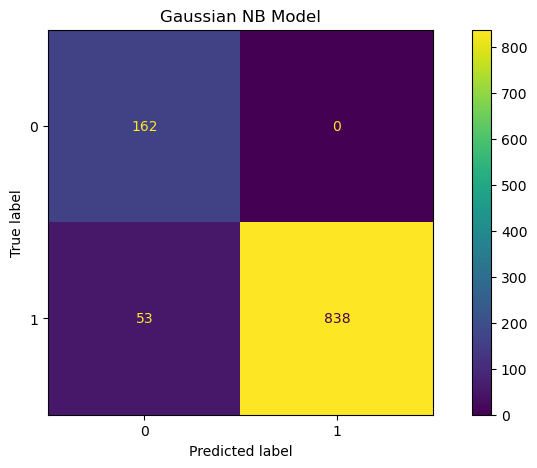

In [157]:
# Preparing confusion matrices plots
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
display_bnb = ConfusionMatrixDisplay(cm_gau)
ax.set(title='Gaussian NB Model')
display_bnb.plot(ax=ax);

#### RANDOM FOREST

In [158]:
# Proceeding with the fitting 
rf_fit_train = rf.fit(X_train_transformed, y_train)
rf_fit_test = rf.fit(X_test_transformed, y_test)
# Proceeding with the predicting
rf_pred_train = rf.predict(X_train_transformed)
rf_pred_test = rf.predict(X_test_transformed)

In [161]:
# Preparing scores reports
rf_report_train = pd.DataFrame(classification_report(y_train, rf_pred_train, output_dict=True)).transpose()
rf_report_train
rf_report_test =  pd.DataFrame(classification_report(y_test, rf_pred_test, output_dict=True)).transpose()
rf_report_test

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,162.000000
1,0.846154,1.000000,0.916667,891.000000
accuracy,0.846154,0.846154,0.846154,0.846154
macro avg,0.423077,0.500000,0.458333,1053.000000
weighted avg,0.715976,0.846154,0.775641,1053.000000


In [162]:
# Preparing confusion matrices
cm_rf = confusion_matrix(y_test, rf_pred_test)

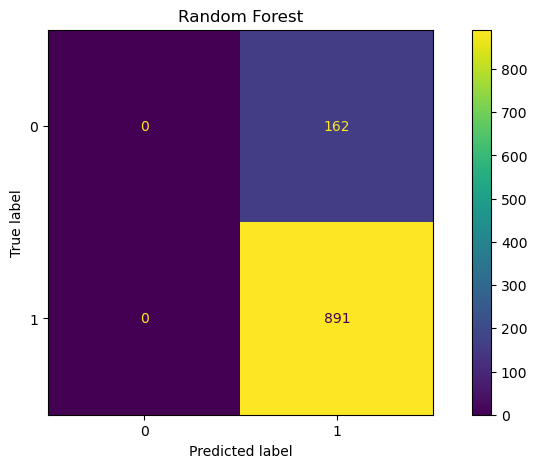

In [164]:
# Preparing confusion matrices plots
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
display_rf = ConfusionMatrixDisplay(cm_rf)
ax.set(title='Random Forest')
display_rf.plot(ax=ax);

#### SUPPORT VECTOR MACHINE 

In [165]:
# Proceeding with the fitting 
svm_fit_train = svc.fit(X_train_transformed, y_train)
svm_fit_train = svc.fit(X_test_transformed, y_test)
# Proceeding with the predicting
svm_pred_train = svc.predict(X_train_transformed)
svm_pred_test = svc.predict(X_test_transformed)

In [166]:
# Preparing the scores reports
svm_report_train = pd.DataFrame(classification_report(y_train, svm_pred_train,output_dict=True)).transpose()
svm_report_train
svm_report_test = pd.DataFrame(classification_report(y_test, svm_pred_test,output_dict=True)).transpose()
svm_report_test

,precision,recall,f1-score,support
0,1.000000,0.611111,0.758621,162.000000
1,0.933962,1.000000,0.965854,891.000000
accuracy,0.940171,0.940171,0.940171,0.940171
macro avg,0.966981,0.805556,0.862237,1053.000000
weighted avg,0.944122,0.940171,0.933972,1053.000000


In [167]:
# Calculating the confusion matrices
cm_svm = confusion_matrix(y_test, svm_pred_test)

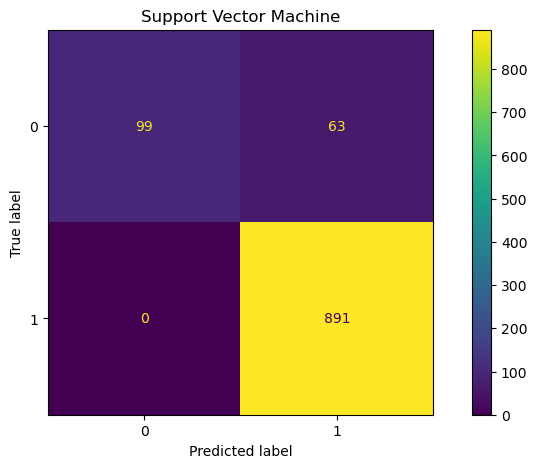

In [168]:
# Preparing confusion matrices plots
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
display_svm = ConfusionMatrixDisplay(cm_svm)
ax.set(title='Support Vector Machine')
display_svm.plot(ax=ax);

### ROC and AUC SCORES

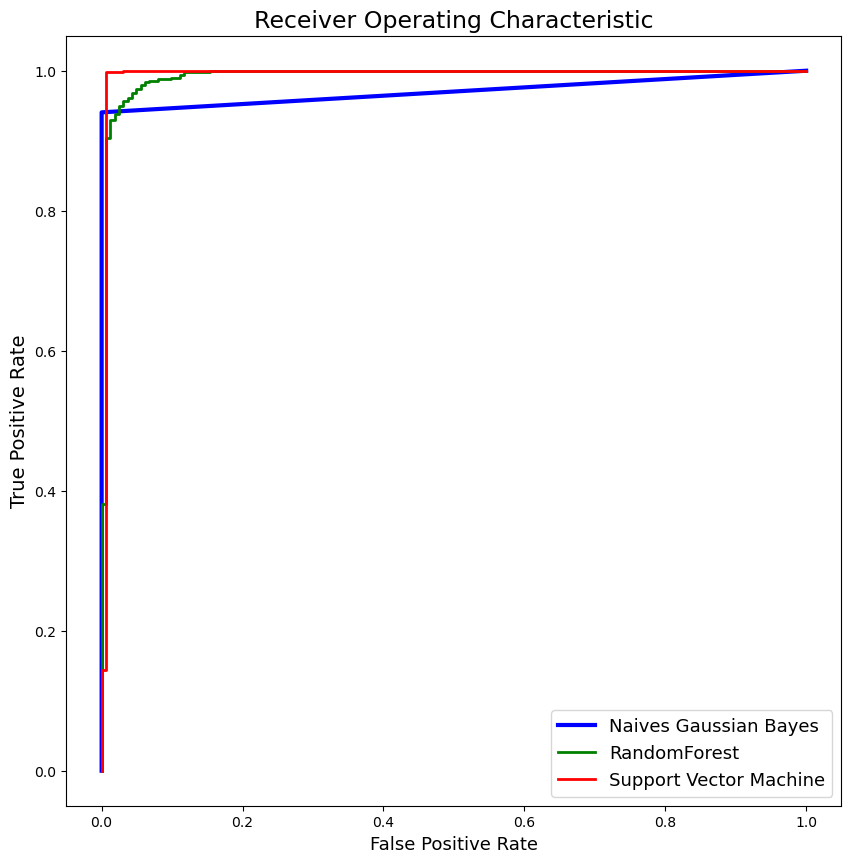

In [169]:
# Plotting the AUC and ROC score
plt.figure(figsize=(10,10))

# naive gaussian
y_score_gau = gau.predict_proba(X_test_transformed)
fpr_gau, tpr_gau, thresholds_gau = roc_curve(y_test, y_score_gau[:, 1])
plt.plot(fpr_gau, tpr_gau, color='blue', lw=3, label='Naives Gaussian Bayes')

# random forest
y_score_rf = rf.predict_proba(X_test_transformed)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_score_rf[:,1])
plt.plot(fpr_rf, tpr_rf, color='green',lw=2, label='RandomForest')

# support vector machine
y_score_svm = svc.predict_proba(X_test_transformed)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_score_svm[:,1])
plt.plot(fpr_svm, tpr_svm, color='red',
lw=2, label='Support Vector Machine')


plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [170]:
auc_gau = auc(fpr_gau, tpr_gau)
auc_rf = auc(fpr_rf, tpr_rf)
auc_svm = auc(fpr_svm, tpr_svm)
auc_scores = [auc_gau, auc_rf, auc_svm]
auc_scores = {"Models": models_list, "AUC Scores": auc_scores}

auc_dt = pd.DataFrame(auc_scores)
auc_dt

,Models,AUC Scores
0,Gaussian NB,0.970258
1,Random Forest,0.992719
2,Support Vector Machine,0.994686


# RESULTS DISCUSSION

### TEXT ANALYSIS

It is possible to assess the vast majority of the tweets are positive 84%, over 16% negative.

Apple and its products have the majority of mentions with 28.8% (ipad), 19.1% (apple), 14.2% (ipad and iphone app); Google appears with 14.9%.

As it is possible to assess from the plots most the vast majority of the posts related to the brand and their products are negative.

For APPLE POSITIVE TWEETS
Most frequent words are related to SXSW conference and the pop up stores and the presentation of the new iPad 2 and the iPhone their features like design, case and app, free. 

For APPLE NEGATIVE TWEETS
With the mention again to the SXSW conference, some features are highlighted like battery, button, design, headaches or adjectives like tap worthy, fascist.

For GOOGLE POSITIVE TWEETS
There’s a reference to the SXSW conference while other remarks are network, panel, doodle, party while among its products android and maps occur.

For GOOGLE NEGATIVE TWEETS
With the same reference to the SXSW conference the words appearing are fail, network, circle, launch, business, maps, location, service, social, bing and android.

### MODELING ANALYSIS




Accuracy is the metric generally used to evaluate and compare models. It is calculated by the total number of true positives and true numbers are divided by the total number of observations.
In this case it is possible to state that:
    
- Gaussian NB: 0.95
    
- Random Forest: 0.87
    
- Support Vector Machine: 0.94
    
Accuracy though, can be misleading and it is advisable to consider the other metrics provided, according to the best suitable business scenario.


Given the values assigned in 
    
- True Negatives are the negative tweets correctly identified as negative.



- False negatives are the positive tweets, uncorrectly identified as negative


- True positive are the positive tweets correctly identified as positive.


- False positive are the negative tweets uncorretly identified as positive.

Which customers are important to this company?

False Negatives and False Positives, and specifically False Positives. It is imperative for business companies that rely on "words of mouth" and reviews to engage customers, acquiring new ones and retaining the existing one, to address negative comments, accusations or features. They could potentially damage their reputation and image, two elements for which time and consistency are absolutely necessary.

Given that, it is more important to consider precision and AUC&ROC score.

- Precision. Out of the tweets that the model predicted would be positive, they are actually positive:

    - Gaussian NB: 87%
    - Random Forest: 42%
    - Support Vector Machine: 97%


- ROC and AUC. 

ROC summarizes the performance of a binary classification model on the positive class. AUC function takes both the true outcome from the test set and the predicting set for the positive class.
Support Vector Machine: the model performs almost perfectly discriminating True Positive and False Positive.


I can examine the other metrics as well: 

- Recall. 
Out of all the tweets that are actually positive, the model only predicted this outcome correctly for those:

    - Naive Gaussian Bayes: 97%
    - Random Forest: 61%
    - Support Vector Machine: 80%


- F1 Score. 
This metric indicates how well the model predicts the churning choice. The closer the value is to 1, the better the model performs. Examining the values:

    - Naive Gaussian Bayes: 0.91
    - Random Forest: 0.46
    - Support Vector Machine: 0.93



# CONCLUSION

### TEXT ANALYSIS

The classification of positive and a negative tweets used a tool for the business seemed to be confirmed. 
It consists in the millions of pairs of fresh eyes that scrutinize company and their products, services and reputation and led not only improvements but also innovation, being Twitter a direct line for customer engagement.
Comparing Apple and Google it seems like there is a major focus on the products for Apple, on the community for Google.
However Apple is named as fascist.

### MODELING ANALYSIS

According to the interpretation of these results, among the models used to solve this business problem for Apple and Google, it can be stated that the Support Vector Machine is the model that performs best as a classifier for this dataset, in order to predict the positive and negative reactions of customers based on sentiment analysis of their tweets. 

As the matter of fact, the Support Vector Machine model was able to predict correctly positive tweets with very high degree (precision: 96%, recall 80%, F1 score 93%) results. This trend is also confirmed by the ROC plots which returns a almost perfect capability of identification.

#### RECOMMENDATIONS AND FURTHER RESEARCH

- Users seems to complain about: 
    - Iphone's usability features and related performance like for battery
    - Ipad design
    - Android apps
    - Google maps and network.
    
It would advisable to focus on improving these items.

Alternative forms of customer engagement like conferences, parties and pop stores are highly appreciated. For this reason, it would be recommendable to keep investing on this line.

It would be advisable to invest in furthering the modeling process with more algorythms and parameters manipulation.